## DEMO for the script `bi_sys_id_my_version.py`

This version was developed for the DOE proposal. Main advantage is that it does not assume that the system starts from the null initial state

In [1]:
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from bi_sys_id_my_version import *

In [2]:
# Magnitudes of the controls
v = 2.5
# time step for measurements
dt = 1

In [3]:
def response(*, Ac, Nc, C, x0):
    
    def rhs_eq(x, t, E):
        """
        the rhs of the equation of motion
        """
        return (Ac + Nc * E) @ x
    
    time = dt * np.arange(20)
        
    # save response when only E is on
    responce = []
        
    for n in range(2, 7):
        # response when only u1 is on
        x_on = odeint(rhs_eq, x0, time[:n], args=(v,))
        x_off = odeint(rhs_eq, x_on[-1], time[(n-1):], args=(0.,))[1:]
        
        responce.append(
            np.vstack([x_on, x_off]) @ C
        )
            
    return np.array(responce)

In [4]:
# Matricies from the example in paper
Ac = np.array([[-1.2, 0], [1.1, -2]])
Nc = np.array([[0.1, 0.01], [1, 1]])
C = np.array([1, 1])
x0 = np.random.rand(2)

In [5]:
orig_responces = response(Ac=Ac, Nc=Nc, C=C, x0=x0)

## execute the bilinear system identification

In [6]:
reconstructed = bi_sys_id_my_version(orig_responces, alpha=5, dt=dt, v=[v])

In [7]:
reconstructed

Reconstructed(Ac=array([[-1.78915614,  4.58941772],
       [ 0.02696523, -1.41273755]]), C=array([[-0.98383392,  0.17439154]]), Nc=[array([[ 1.01288498,  0.0466853 ],
       [-0.03811284,  0.08787226]])], x0=array([[-0.90512465],
       [-0.2553527 ]]))

# Comparing the responses that were used to construct the model|


In [12]:
# reconstructed_responces = response(
#     Ac = reconstructed.Ac, 
#     Nc = reconstructed.Nc[0],
#     C = reconstructed.C[0], 
#     x0 = reconstructed.x0.reshape(-1)
# )
times = dt * np.arange(orig_responces.shape[1])

reconstructed_responces = get_training_responses(
    reconstructed, 
    times = times,
    p = 5,
    u = v
)

In [13]:
print(
    "Reconstruction error: ", 
    np.abs(reconstructed_responces - orig_responces).max()
)

Reconstruction error:  0.0001505724525249219


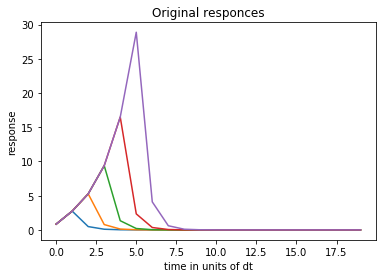

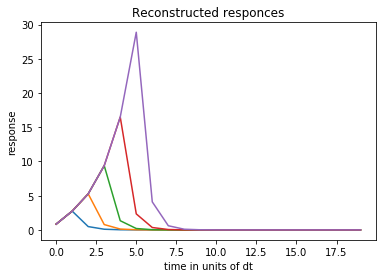

In [14]:
plt.title("Original responces")
plt.plot(orig_responces.T)
plt.xlabel("time in units of dt")
plt.ylabel("response")
plt.show()

plt.title("Reconstructed responces")
plt.plot(reconstructed_responces.T)
plt.xlabel("time in units of dt")
plt.ylabel("response")
plt.show()

# Comparing the predictions

In [71]:
new_u = lambda t: 3 * np.sin(t)

In [72]:
predicted_response = get_response(reconstructed, new_u, times)

In [73]:
actual_response = get_response(
    Reconstructed(Ac=Ac, C=[C], Nc=[Nc], x0=x0),
    new_u,
    times
)

In [74]:
np.abs(predicted_response - actual_response).max()

0.0006385107379323074

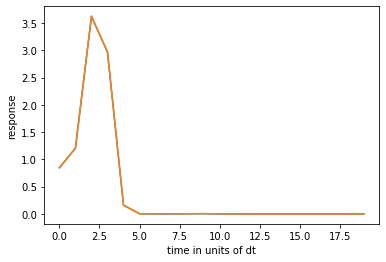

In [76]:
plt.plot(predicted_response)
plt.plot(actual_response)
plt.xlabel("time in units of dt")
plt.ylabel("response")
plt.show()